### Section 0 ++> Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

### Section 1 ++> Importing Data

In [2]:
#os.chdir("/home/abhay/py_envs/anaconda3/20200829_flow_over_cyl/20200809")
os.chdir("C:/Users/Kommalapati sahil/Desktop/MPC_Brunton/data_updates/20200908")

tempvar = np.genfromtxt("rot_speed.txt", delimiter = " ")

t = tempvar[:,0]

upsilon = tempvar[:,1]



del tempvar

tempvar = np.genfromtxt("export0.csv", delimiter = ",", skip_header = 6)
x = tempvar[:,1]
y = tempvar[:,2]

n = x.shape[0]
q=1

del tempvar

press = np.zeros((n,251))
velu = np.zeros((n,251))
velv = np.zeros((n,251))
helicity = np.zeros((n,251))
swstr = np.zeros((n,251))

verbose = 1
for i in range(0,251):
    filename = "export"+str(i)+".csv"
    export = np.genfromtxt(filename, delimiter = ",", skip_header = 6)
    press[:,i] = export[:,4]
    velu[:,i] = export[:,5]
    velv[:,i] = export[:,6]
    helicity[:,i] = export[:,7]
    swstr[:,i] = export[:,12]
    if verbose:
        print(f'Frame - {i}')

del filename
del export

Frame - 0
Frame - 1
Frame - 2
Frame - 3
Frame - 4
Frame - 5
Frame - 6
Frame - 7
Frame - 8
Frame - 9
Frame - 10
Frame - 11
Frame - 12
Frame - 13
Frame - 14
Frame - 15
Frame - 16
Frame - 17
Frame - 18
Frame - 19
Frame - 20
Frame - 21
Frame - 22
Frame - 23
Frame - 24
Frame - 25
Frame - 26
Frame - 27
Frame - 28
Frame - 29
Frame - 30
Frame - 31
Frame - 32
Frame - 33
Frame - 34
Frame - 35
Frame - 36
Frame - 37
Frame - 38
Frame - 39
Frame - 40
Frame - 41
Frame - 42
Frame - 43
Frame - 44
Frame - 45
Frame - 46
Frame - 47
Frame - 48
Frame - 49
Frame - 50
Frame - 51
Frame - 52
Frame - 53
Frame - 54
Frame - 55
Frame - 56
Frame - 57
Frame - 58
Frame - 59
Frame - 60
Frame - 61
Frame - 62
Frame - 63
Frame - 64
Frame - 65
Frame - 66
Frame - 67
Frame - 68
Frame - 69
Frame - 70
Frame - 71
Frame - 72
Frame - 73
Frame - 74
Frame - 75
Frame - 76
Frame - 77
Frame - 78
Frame - 79
Frame - 80
Frame - 81
Frame - 82
Frame - 83
Frame - 84
Frame - 85
Frame - 86
Frame - 87
Frame - 88
Frame - 89
Frame - 90
Frame - 9

### Visualizing the U profile - Rotation speed 

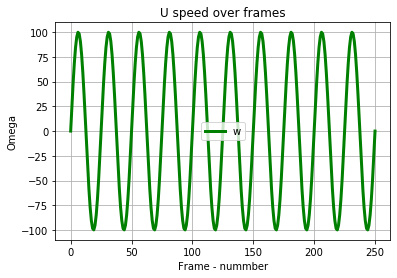

In [8]:
plt.plot(upsilon, '-g', lineWidth = 3, label = 'w')
plt.grid()
plt.xlabel('Frame - nummber')
plt.ylabel('Omega')
plt.title('U speed over frames')
plt.legend()

### Visualizing the flow data - Swirling Strength

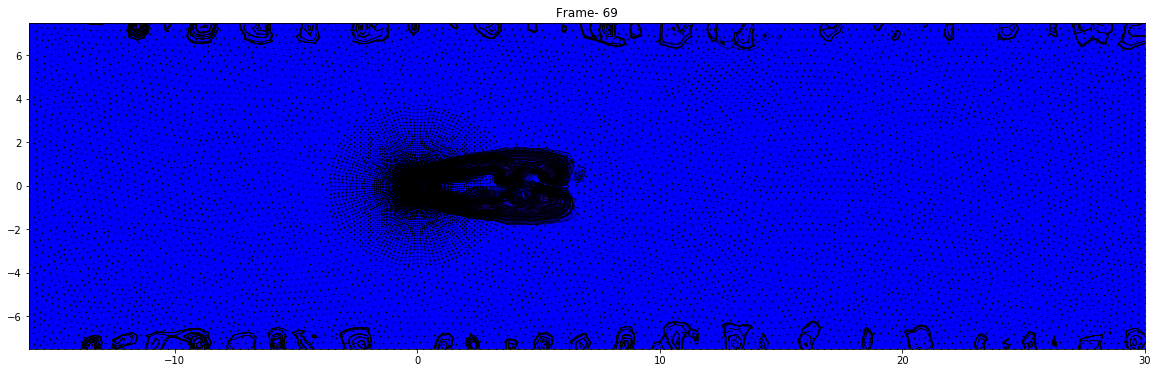

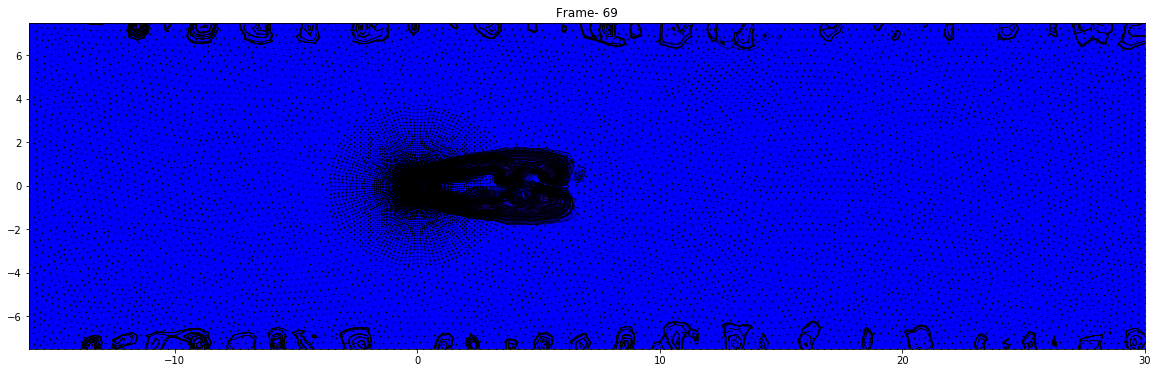

In [3]:
start_frame = 59
end_frame = 70

from IPython.display import display, clear_output
%matplotlib inline


fig,ax2 = plt.subplots(1,figsize=(20,6))
z = swstr[:,i]
ax2.tricontour(x, y, z, levels=100, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, z, levels=100, cmap='brg')
ax2.plot(x, y, 'ko', ms=0.1)
ax2.set_title(f'Frame- {str(i)}')

for i in range(start_frame+1,end_frame):
    
    z = np.real(swstr[:,i])
    ax2.tricontour(x, y, z, levels=100, linewidths=0.5, colors='k')
    cntr2 = ax2.tricontourf(x, y, z, levels=100, cmap='brg')
    ax2.plot(x, y, 'ko', ms=0.1)
    ax2.set_title(f'Frame- {str(i)}')
    clear_output(wait = True)
    display(fig)
    
#clear_output()

### Section 2 ++> Dynamic Mode Decomposition with Control

#### Subsection 2.1 - Setting up Xa and X2

In [4]:
#forming X matrix using U, V and Swirling strength values

In [5]:
X = np.vstack((velu,velv,swstr))

X1 = X[:,:-1]
X2 = X[:,1:]

upsilon = upsilon[:-1]

Omega = np.vstack((X1,upsilon))

U, S, V = np.linalg.svd(Omega, full_matrices=False)

S = np.diag(S)

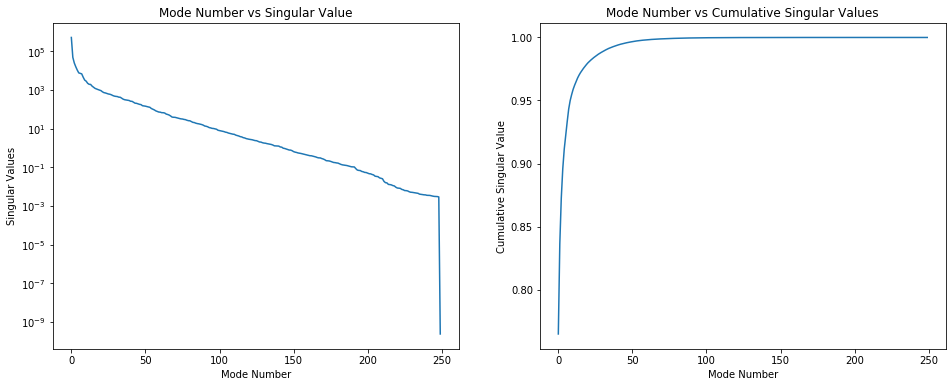

In [6]:
## Semilog of Sig and use that for deciding r

plt.figure(figsize = (16, 6))

plt.subplot(121)

plt.semilogy(np.diag(S))

plt.xlabel("Mode Number")

plt.ylabel("Singular Values")

plt.title("Mode Number vs Singular Value")

plt.subplot(122)

I = np.cumsum(np.diag(S))/np.sum(S)
#np.diag(S) added

plt.plot(I)

plt.xlabel("Mode Number")

plt.ylabel("Cumulative Singular Value")

plt.title("Mode Number vs Cumulative Singular Values")

plt.show()

In [7]:
len(np.cumsum(np.diag(S)))

250

#### Subsection 2.2 - Truncation

In [8]:
## Semilog of S and use that for deciding rtil
del I

rtil = 50 # for now

Util = U[:,:rtil]
Sigtil = S[:rtil,:rtil]
Vtil = V[:,:rtil]

del U
del V

U, Sig, V = np.linalg.svd(X2, full_matrices=False)

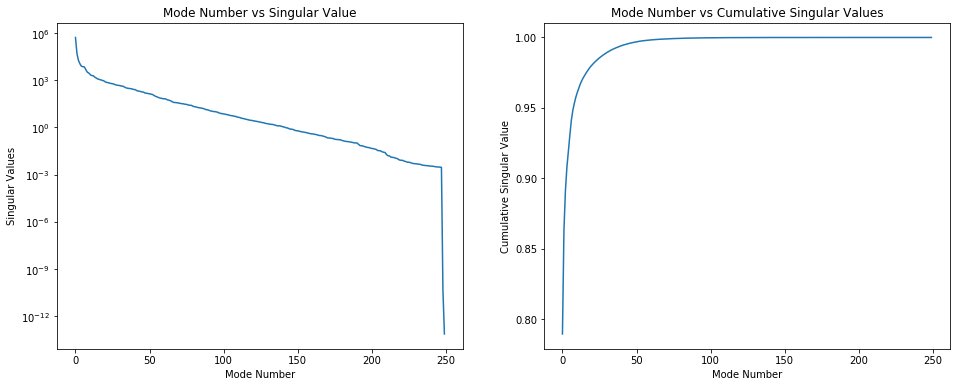

In [9]:
## Semilog of Sig and use that for deciding r

plt.figure(figsize = (16, 6))

plt.subplot(121)

plt.semilogy(Sig)

plt.xlabel("Mode Number")

plt.ylabel("Singular Values")

plt.title("Mode Number vs Singular Value")

plt.subplot(122)

I = np.cumsum(Sig)/np.sum(Sig)

plt.plot(I)

plt.xlabel("Mode Number")

plt.ylabel("Cumulative Singular Value")

plt.title("Mode Number vs Cumulative Singular Values")

plt.show()

In [10]:
Sig.shape

(250,)

In [11]:
Sig_ = np.diag(Sig)

r = 50;
Uhat    = U[:,:r] 
Sighat  = Sig_[:r,:r]
Vbar    = V[:,:r]

U1 = Util[:-1,:]
U2 = Util[n+q:n+q+1,:]

#### Subsection 2.3 - Estimating approximate A and B matrices

In [12]:
Uhat.shape

(77442, 50)

In [13]:
approxA = ((((Uhat.T @ X2) @ Vtil) @ np.linalg.inv(Sigtil)) @ U1.T) @ Uhat

approxB = (((Uhat.T @ X2) @ Vtil) @ np.linalg.inv(Sigtil)) @ U2.T

approxB = approxB.reshape((r,))

#### Subsection 2.4 - Estimating the DMD Modes

In [14]:
w, v = np.linalg.eig(approxA)

w = np.diag(w)


Phi = ((X2 @ Vtil) @ np.linalg.inv(Sigtil)) @ (U1.T @ Uhat @ v)

Phi_u = Phi[:n,:]
Phi_v = Phi[n:2*n,:]
Phi_swstr  = Phi[2*n:3*n,:]

#### Subsection 2.4 - Plotting the DMD Modes

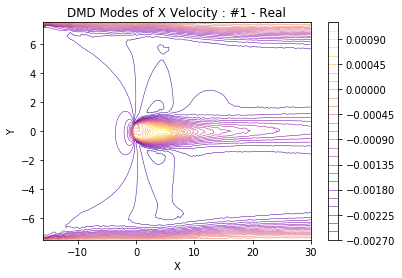

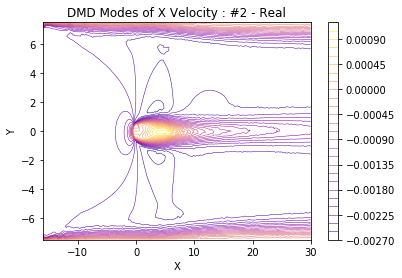

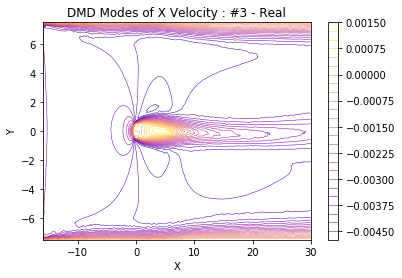

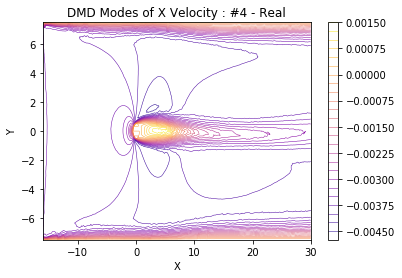

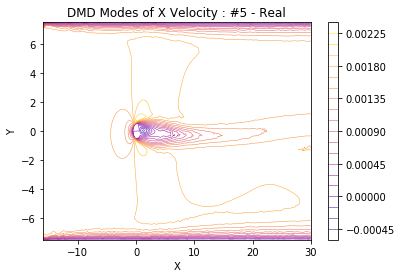

In [15]:
for i in range(5):
    name = "DMD Modes of X Velocity : #" + str(i+1) + " - Real"
    plt.tricontour(x,y,np.real(Phi_u[:,i]),levels=25, linewidths = 0.5, cmap = 'plasma')
    plt.colorbar(cax=None, orientation = 'vertical')
    plt.title(name)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

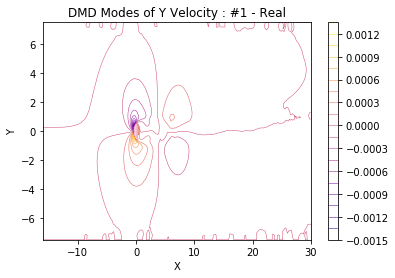

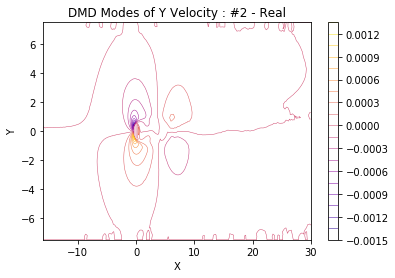

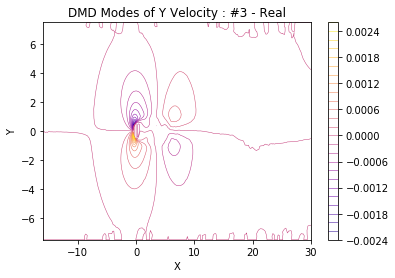

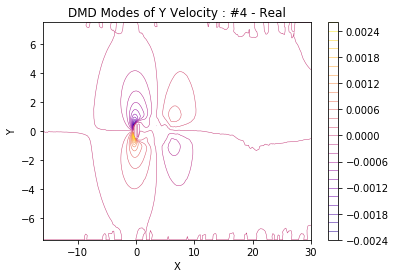

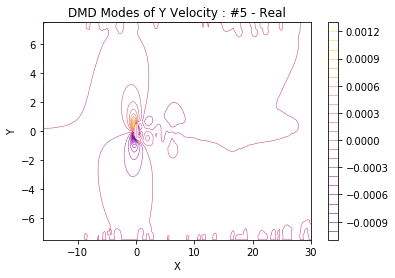

In [16]:
for i in range(5):
    name = "DMD Modes of Y Velocity : #" + str(i+1) + " - Real"
    plt.tricontour(x,y,np.real(Phi_v[:,i]),levels=25, linewidths = 0.5, cmap = 'plasma')
    plt.colorbar(cax=None, orientation = 'vertical')
    plt.title(name)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

### Section 3 ++> Using the ROM in form of a (x+) = Ax+Bu system

#### Subsection 3.1 - Reconstructing full state from reduced states

In [18]:
# convert from truncated state to full state - xfull = Util@xtil

tsteps = t.shape[0]

xfull0 = X1[:,0]
xtrunc = np.zeros((r,251))
                  
                  
xtrunc[:,0] = np.linalg.pinv(Uhat)@xfull0

for i in range(tsteps-1):
    xtrunc[:,i+1] = approxA @ xtrunc[:,i] + approxB * upsilon[i]

xfull = Uhat@xtrunc

ureconstructed = xfull[:n,:]
vreconstructed = xfull[n:2*n,:]
swstreonstructed = xfull[2*n:3*n,:]

### Section 4 ++> Error Analysis

In [19]:
errs = []
for i in range(len(X[0,:])):
    err  = np.abs( X[:,i]- xfull[:,i])/(X[:,i]+0.001)*100
    errs.append(np.nanmean(err))

Text(0.5, 1.0, 'Error Percentage - frames 50 to 250')

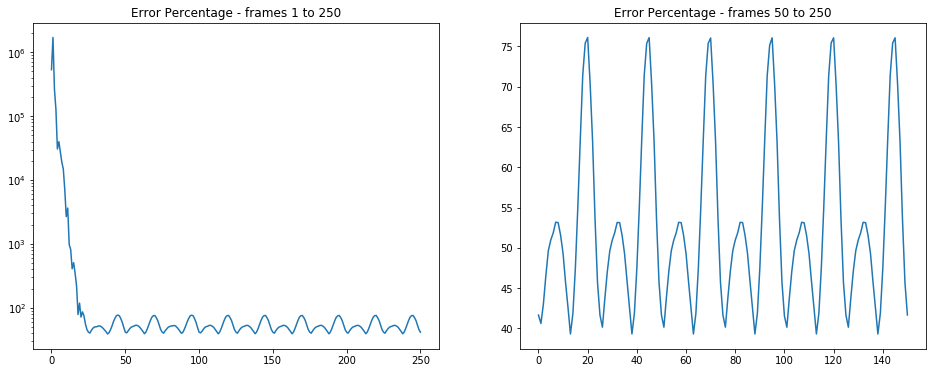

In [20]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.semilogy(errs)
plt.title('Error Percentage - frames 1 to 250')

plt.subplot(1,2,2)
plt.plot(errs[100:])
plt.title('Error Percentage - frames 50 to 250')



In [21]:
print(f' ~ Average error {round(np.mean(errs[50:]),4)} %')

 ~ Average error 52.929 %


In [ ]:
'''
#Future Steps:
1. put A and B in mpc and supress swirlling strength 
2. obtain a new u field based on MPC and validate results on linearized model. (Finally on ansys)
3. How can the error be reduced?

4. would a simple feedback control do the job?
'''

### Section 5 ++> Exporting data

In [ ]:
import scipy.io as sio
#export as .mat files

sio.savemat('apxA.mat', {'vect':approxA}) #A
sio.savemat('apxB.mat', {'vect':approxB}) #B

sio.savemat('x0.mat', {'vect':xtrunc[:,0]}) #x0
sio.savemat('Uhat.mat', {'vect':Uhat}) #uhat - to get x full from x trunc
